In [46]:
pip install -qq transformers

Note: you may need to restart the kernel to use updated packages.


In [47]:
!pip install -q -U watermark

In [48]:
!pip install -q -U seaborn

In [49]:
!pip install --quiet datasets
!pip install --quiet emoji
!pip install --quiet kaggle
!pip install --quiet torchinfo
!pip install --quiet imbalanced-learn
!pip install --quiet gdown

In [50]:
!pip install --quiet nltk

In [51]:
!pip install -q -U pandas
!pip install -q -U torch

In [1]:
import transformers
from torch.utils import data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# data processing
import re, string
import emoji
import nltk

# dataset
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

# preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

import re, string

from tqdm import tqdm
from collections import defaultdict

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johnnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
models = ["distilbert-base-uncased", "bert-base-uncased", "bert-base-cased"]
modelName = models[2] 

In [8]:
df_train = pd.read_csv("Corona_NLP_train.csv",encoding='latin-1')
print(df_train)
print(df_train.columns)

KeyError: 0

In [55]:
df_train = df_train[["OriginalTweet", "Sentiment"]]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [56]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)
df_train = df_train.rename({'OriginalTweet': 'Reviews'}, axis='columns')
df_train['Sentiment']=df_train['Sentiment'].replace({'Neutral':1, 'Positive':2,'Extremely Positive':2, 'Extremely Negative':0,'Negative':0})
df_train['Sentiment']=df_train['Sentiment'].astype(int)

df_train = df_train.reset_index(drop=True)
df_train.head()

,Reviews,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia: Woolworths to give elde...,2
3,My food stock is not the only one which is emp...,2
4,"Me, ready to go at supermarket during the #COV...",0


In [57]:
df_train.isnull().sum()

Reviews      0
Sentiment    0
dtype: int64

In [58]:
df_train["Sentiment"].value_counts()

2    18046
0    15398
1     7713
Name: Sentiment, dtype: int64

In [59]:
# word tokenizer
df_train['Reviews_len_by_words'] = df_train['Reviews'].apply(lambda t: len(t.split()))
min_len_word, max_len_word = df_train['Reviews_len_by_words'].min(), df_train['Reviews_len_by_words'].max()
print(min_len_word, max_len_word)

1 64


<AxesSubplot: xlabel='Reviews_len_by_words', ylabel='Count'>

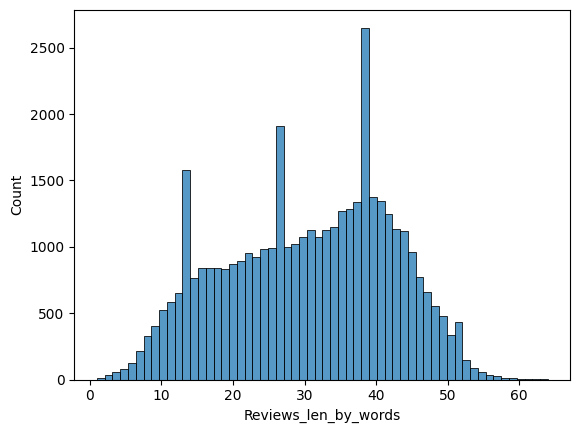

In [60]:
sns.histplot(df_train['Reviews_len_by_words'])

In [61]:
df_train.describe()

,Sentiment,Reviews_len_by_words
count,41157.000000,41157.000000
mean,1.064339,30.500304
std,0.899153,11.591172
min,0.000000,1.000000
25%,0.000000,21.000000
50%,1.000000,32.000000
75%,2.000000,40.000000
max,2.000000,64.000000


[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

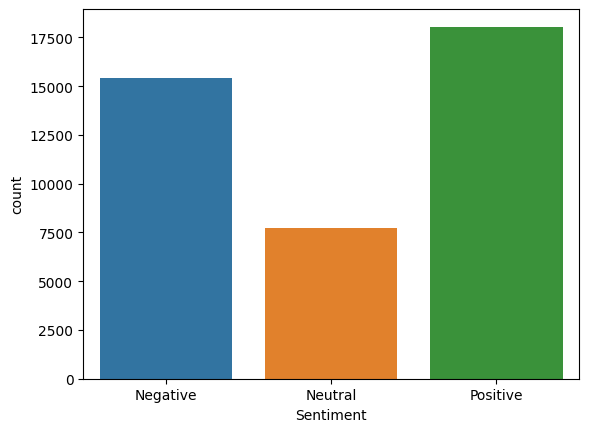

In [62]:
class_names = ['Negative', 'Neutral', 'Positive']
ax = sns.countplot(x='Sentiment', data=df_train)
ax.set_xticklabels(class_names)

In [63]:
df_test = pd.read_csv("Corona_NLP_test.csv",encoding='latin')
df_test = df_test.drop(labels=['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
df_test.drop_duplicates(subset='OriginalTweet',inplace=True)

df_test = df_test.rename({'OriginalTweet': 'Reviews'}, axis="columns")

df_test['Sentiment']=df_test['Sentiment'].replace({'Neutral':1, 'Positive':2,'Extremely Positive':2, 'Extremely Negative':0,'Negative':0})
df_test['Sentiment']=df_test['Sentiment'].astype(int)
df_test = df_test.reset_index(drop=True)

df_test.head()

,Reviews,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
1,When I couldn't find hand sanitizer at Fred Me...,2
2,Find out how you can protect yourself and love...,2
3,#Panic buying hits #NewYork City as anxious sh...,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1


In [64]:
print(df_train.shape , df_test.shape)
df_train, df_val = train_test_split(df_train, test_size=0.09, random_state=RANDOM_SEED, stratify=df_train['Sentiment'])
print(df_train.shape , df_val.shape, df_test.shape)

(41157, 3) (3798, 2)
(37452, 3) (3705, 3) (3798, 2)


In [65]:
def createDataset(df, textCol, labelCol):
  dataset_dict = {
    'text' : df[textCol],
    'labels' : df[labelCol],
  }
  sent_tags = ClassLabel(num_classes=3 , names=[ 'Negative','Neutral','Positive'])

  return Dataset.from_dict(
    mapping = dataset_dict,
    features = Features({'text' : Value(dtype='string') , 'labels' :sent_tags})
  )

In [66]:
dataset_train = createDataset(df_train,"Reviews","Sentiment")
dataset_val = createDataset(df_val,"Reviews","Sentiment")
dataset_test = createDataset(df_test,"Reviews","Sentiment")

dataset_sentAnalysis = DatasetDict()
dataset_sentAnalysis["train"] = dataset_train
dataset_sentAnalysis["val"] = dataset_val
dataset_sentAnalysis["test"] = dataset_test

dataset_sentAnalysis

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 37452
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 3705
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3798
    })
})

In [67]:
#Data Preprocessing

In [68]:
def convert_to_lower(text):
    return text.lower()

def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)

    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    return wierd_pattern.sub(r'', text)

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def preprocessText(text):
  return remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(text))))))

def preprocessBatch(batch):
  new_list = []
  for i in batch["text"]:
    new_list.append(remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(i)))))))
  batch["text"] = new_list
  return batch

In [69]:
dataset_sentAnalysis_preprocessed = dataset_sentAnalysis.map(preprocessBatch, batched=True, batch_size=32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 169.76ba/s]


In [70]:
dataset_sentAnalysis["train"][10]

{'text': 'Doing a little online #coronavirus #shopping here in #China in #coronavirus quarantine--gonna put Anubis in this... https://t.co/AVNKyxUPfO',
 'labels': 1}

In [71]:
dataset_sentAnalysis_preprocessed["train"][10]

{'text': 'little online coronavirus shopping china coronavirus quarantinegonna put anubis',
 'labels': 1}

In [72]:
#Tokenizer

In [73]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(modelName)

In [74]:
max_len = 128
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=max_len)

In [75]:
sample_text = "What is  going on @resturant.:( It makes   Me Feel Upset.😞"
tokens = tokenizer.tokenize(sample_text)
print(len(tokens), tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids), token_ids)

token_dictionary = tokenizer(sample_text)
print(token_dictionary)
print(len(token_dictionary.input_ids)) # automatically added cls, sep

tokens = tokenizer.convert_ids_to_tokens(token_dictionary['input_ids'])
print(tokens)

token_encode = tokenizer.encode(sample_text) #convert to tokens ids but with cls+sep
print(token_encode)

19 ['What', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'It', 'makes', 'Me', 'Feel', 'Up', '##set', '.', '[UNK]']
19 [1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100]
{'input_ids': [101, 1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
21
['[CLS]', 'What', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'It', 'makes', 'Me', 'Feel', 'Up', '##set', '.', '[UNK]', '[SEP]']
[101, 1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100, 102]


In [76]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt",truncation=True
)
encoding

/opt/homebrew/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[  101,  1327,  1110,  1280,  1113,   137,  1832,  4084,  2227,   119,
           131,   113,  1135,  2228,  2508, 14425,  3725,  9388,   119,   100,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [77]:
dataset_sentAnalysis_encoded = dataset_sentAnalysis_preprocessed.map(tokenize, batched=True, batch_size=32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 435.96ba/s]


In [78]:
dataset_sentAnalysis_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 37452
    })
    val: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3705
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3798
    })
})

In [79]:
# Add Classification head manually for Model

In [80]:
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # Load model body > return all og the HS
        self.bert = BertModel(config)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to encoder representation > [cls]
        sequence_output = self.dropout(outputs[1])
        logits = self.classifier(sequence_output)

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [81]:
from transformers import AutoConfig

id2label = {
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'
}

label2id = { v:k for (k,v) in id2label.items()}

bert_config = AutoConfig.from_pretrained(modelName, 
                                         num_labels=5,
                                         id2label=id2label, label2id=label2id)

In [82]:
bert_model = (BertForClassification
              .from_pretrained(modelName, config=bert_config)
              .to(device))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForClassification were not initialized from the model checkpoint at bert-base-cased and are newly ini

In [83]:
#Training Arguments

In [84]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(dataset_sentAnalysis_encoded["train"]) // batch_size
model_name = f"{modelName}-finetuned-sentimentAnalysis-bert"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch", 
                                  save_steps=1e6,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  run_name="bert-sent-analysis")

In [85]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [86]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(bert_model.parameters(), lr=2e-5)

num_epochs = 4
num_training_steps = num_epochs * logging_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

trainer_preprocessed_lr = Trainer(model=bert_model, args=training_args,
                                  compute_metrics=compute_metrics,
                                  train_dataset=dataset_sentAnalysis_encoded["train"],
                                  eval_dataset=dataset_sentAnalysis_encoded["val"],
                                  tokenizer=tokenizer,
                                  optimizers=(optimizer,lr_scheduler))

trainer_preprocessed_lr.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.527400,0.393123,0.863968,0.862913
2,0.340800,0.368672,0.882591,0.882152
3,0.255000,0.394971,0.886640,0.885978
4,0.194000,0.443209,0.884211,0.883875


TrainOutput(global_step=9364, training_loss=0.3291851248510981, metrics={'train_runtime': 14941.0398, 'train_samples_per_second': 10.027, 'train_steps_per_second': 0.627, 'total_flos': 5733876727406952.0, 'train_loss': 0.3291851248510981, 'epoch': 4.0})

In [87]:
#Evaluation

In [88]:
model = bert_model
model.eval()
preds_output = trainer_preprocessed_lr.predict(dataset_sentAnalysis_encoded["test"])
pd.DataFrame(list(preds_output.metrics.items())).T

,0,1,2,3,4,5
0,test_loss,test_accuracy,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
1,0.542224,0.860453,0.860318,66.8999,56.771,3.558


In [89]:
PATH = "./bert-classification-classification-head"
torch.save(bert_model.state_dict(), PATH)

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

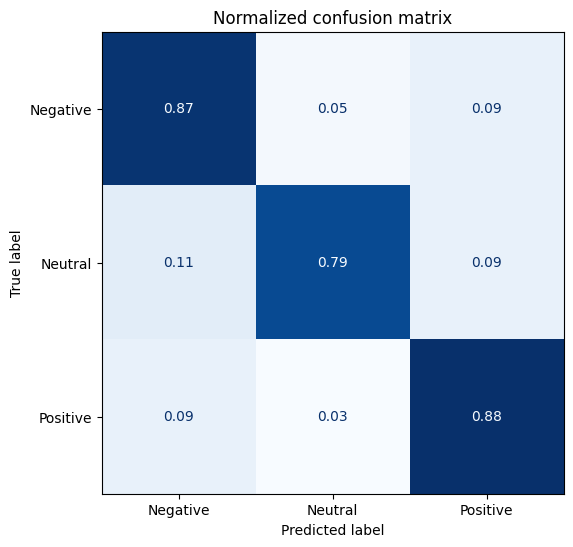

In [91]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(dataset_sentAnalysis_encoded["test"]["labels"])
labels = dataset_sentAnalysis_encoded["train"].features["labels"].names
plot_confusion_matrix(y_preds, y_test, labels)

In [94]:
from sklearn.metrics import confusion_matrix, classification_report

class_names =  ['Negative','Neutral', 'Positive']
print(classification_report(y_test, y_preds, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87      1633
     Neutral       0.81      0.79      0.80       619
    Positive       0.87      0.88      0.88      1546

    accuracy                           0.86      3798
   macro avg       0.85      0.85      0.85      3798
weighted avg       0.86      0.86      0.86      3798



In [109]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

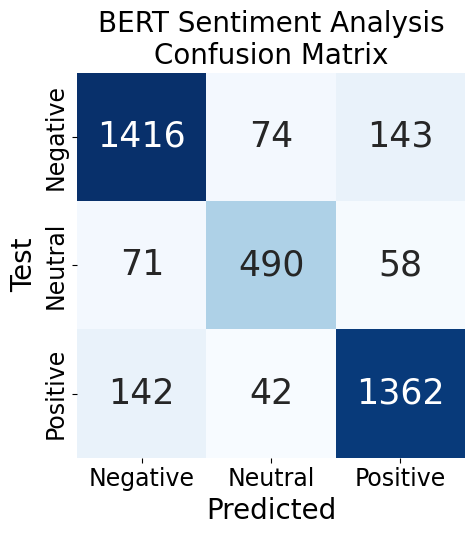

In [112]:
conf_matrix(y_test,y_preds,'BERT Sentiment Analysis\nConfusion Matrix')

In [95]:
import numpy as np
import torch.nn.functional as F

def predict_text(model,text):
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
  inputs = {k:v.to(device) for k,v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  out = F.softmax(outputs.logits,dim=1)
  y_out = np.argmax(out.cpu(),axis=1)
  return out, y_out

In [101]:
sample_text = "I love the movies, eshay bad tho"
out, y_out = predict_text(model,sample_text)
out, id2label[y_out.item()]

(tensor([[9.6289e-02, 1.2552e-01, 7.7813e-01, 2.7661e-05, 2.7568e-05]]),
 'Neutral')

In [104]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame({
    "Text": sample_text,
    "Sentiment": class_names[y_out.item()]
},index=[0]).T


,0
Text,"I love the movies, eshay bad tho"
Sentiment,Positive
